<a href="https://colab.research.google.com/github/OmdenaAI/KenyaRedCross/blob/main/Supervised_learning/3_channels_U_Net_LCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install fastai --upgrade
!pip install rasterio

In [2]:
from matplotlib import pyplot as plt
import numpy
from fastai.vision.all import *
import rasterio as rio

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fastai as high-level API will be used on top of PyTorch to train the model. For fastai documentation, please refer [here](https://docs.fast.ai/).


## Load the data

The data is contained in the Kenya Red Cross Google Drive folder in the [**landcovernet** subfolder](https://drive.google.com/drive/folders/1RXW137kpijk9T-_eexeE39OjBKQrcBdK).

Here is the structure of our data:

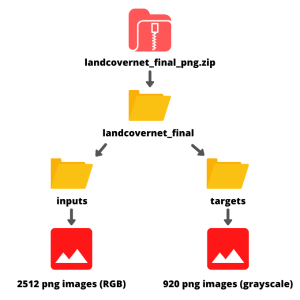

For every target, there are up to 4 corresponding input images. This is because we have downloaded several input images for different seasons of the year. For more information on the data downloading approach, please refer [here](https://github.com/OmdenaAI/KenyaRedCross/tree/main/Landcovernet%20Dataset).

In [ ]:
%%capture
!unzip "drive/My Drive/Omdena/Data/landcovernet/landcovernet_final_png.zip"

In [ ]:
path = Path('landcovernet_final')

In [ ]:
path_img = path/'inputs'
path_lbl = path/'targets'

In [ ]:
fnames = get_image_files(path_img)

In the data, there are up to 4 inputs that correspond to each label mask, that's why there are more inputs (2512 images) than targets (920 images). To find corresponding target for each input, you need to remove the month and date (4 last numbers after 2018) as well as `_RGB.png` and add `_LC_10m.png`.

Example:

`28QDE_00_20180103_RGB.png` --> Input

`28QDE_00_2018_LC_10m.png` --> Target

We specify this in our `get_y_function` below:

In [ ]:
def get_y_fn(x) :
  return path_lbl/f'{re.findall(r"(.*2018)[0-9]+_RGB", x.stem)[0]}_LC_10m.png'

Checking if this works:

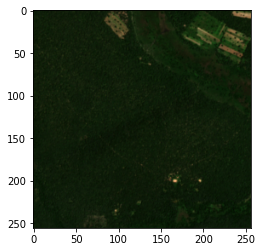

In [ ]:
plt.imshow(plt.imread(fnames[27]))

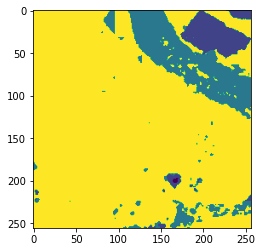

In [ ]:
plt.imshow(plt.imread(get_y_fn(fnames[27])))

Now, we have to specify codes that are our classes to map them with the integer values in the output masks. Our classes are:

- "Otherland" = 0
- "Cropland" = 1
- "Pastureland" = 2
- "Bare soil" = 3
- "Open water" = 4
- "Forestland" = 5

In [ ]:
codes = np.array(['Otherland',
                  'Cropland', 
                  'Pastureland',
                  'Bare soil',
                  'Openwater',
                  'Forestland'])

# Create Dataloaders

First, we create a [DataBlock](https://docs.fast.ai/data.block.html#DataBlock). With it, we can easily build `Datasets` and `Dataloaders` to feed our data into the model. To build a `DataBlock`, we need to provide several things:

- `blocks` = the types of inputs/labels
- `get_items` = function to get inputs
- `get_y` = function to find targets that correspond to inputs
- `splitter` = function to split our data into training and validation set

Other parameters are optional. To adjust our data so that it fits pretrained Imagenet model as much as possible, we will:
- Crop the images to 224x224 pixels. This is done with `RandomResizedCrop` function as an item transform. (Item transforms are transforms that happen on every training sample before creating a batch from them)
- Normalize images using Imagenet parameters. This is done after cropping images on the whole batch of images, therefore, `batch_tfms`

In [ ]:
lcn = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items = get_image_files,
                get_y = get_y_fn,
                splitter = RandomSplitter(valid_pct=0.1),
                item_tfms = RandomResizedCrop(224, min_scale=0.35),
                batch_tfms = Normalize.from_stats(*imagenet_stats))

`DataBlock().summary(path_to_inputs)` allows us to see the whole data pipeline summarized which makes debugging much easier in case of tracebacks later.

In [ ]:
lcn.summary(path_img)

Setting-up type transforms pipelines
Found 2512 items
2 datasets of sizes 2261,251
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y_fn -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      landcovernet_final/inputs/35KNT_26_20181002_RGB.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: get_y_fn -> PILBase.create
    starting from
      landcovernet_final/inputs/35KNT_26_20181002_RGB.png
    applying get_y_fn gives
      landcovernet_final/targets/35KNT_26_2018_LC_10m.png
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Found 2512 items
2 datasets of sizes 2261,251
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y_fn -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.35, 'ratio': (0.75, 1.3333333333333333), 'resamples': 

Finally, we create `Dataloaders` using our `DataBlock`. We will use a batch size of only 8 samples, because segmentation task is very resource-consuming and training even with the GPUs that Google Colab provides (like NVidia Tesla V100 with 16 GB) throws CUDA-out-of-memory errors.

In [ ]:
dls = lcn.dataloaders(source=path_img, path=path, bs=8)

We will need to create a custom metric function to assess the performance of our model. The predictions of the model will have the shape of:

`batch_size x number_of_classes x img_height x img_width` 

Therefore, we want to pick the prediction with the highest probability on dimension 1 (`number_of_classes`) to know which class is the most likely to be present in this particular pixel of the image. We do the following:
1. Compare the predicted class with the target class using `==` --> Returns True/False 
2. Convert True/False to 0/1 using `.float()` method
3. Find mean of the whole batch using `.mean()` method

In [ ]:
def segm_acc(input, target) :
  target = target.squeeze(1)
  return (input.argmax(dim=1)==torch.tensor(target)).float().mean()

### Train ResNet50

Fastai automatically downloads ResNet50 that was pretrained on Imagenet for us, and constructs a U-Net model with ResNet50 as the encoder of the model.

In [ ]:
learn = unet_learner(dls, resnet50, metrics=segm_acc)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


First, we find the suitable learning rate. A good value for the learning rates is then either:

- One tenth of the minimum before the divergence 
- When the slope is the steepest

Those two values are returned by default by the Learning Rate Finder.

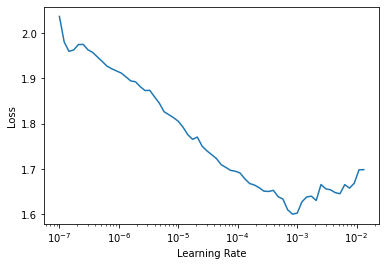

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_min, lr_steep

(8.317637839354575e-05, 0.0005754399462603033)

Now, the strategy is the following:

1. Train only the final layer for a few epochs. This layer will need the most optimization because the parameters of it just got completely randomly assigned.
2. Unfreeze the model and optimize all of its parameters. 

We start from the end of the model and move gradually towards the beginning of it because the last layers of the model pretrained on ImageNet are probably of not much use because they are not specialized to classify satellite images. On the contrary, the first layers of the pretrained model recognize very general features (like gradients and lines) will probably be of more use because these features will still be present in our images. 

First, we train the model during 3 epochs, only tweaking the head parameters of the model, i.e. its final layer. The rest of the layers will remain unchanged or "frozen".

In [ ]:
learn.fit_one_cycle(3, lr_max=lr_min)

epoch,train_loss,valid_loss,segm_acc,time
0,1.108984,1.054580,0.575925,11:33
1,0.935173,0.743443,0.718808,11:25
2,0.763114,0.702529,0.738428,11:22


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Now, we unfreeze the rest of the layers, so that we can optimize them as well.

In [ ]:
learn.unfreeze()

Find a new good learning rate, since the model has changed after training 3 epochs.

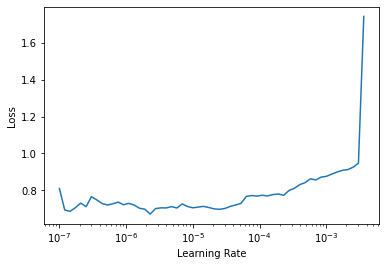

In [ ]:
lr_min, lr_steep = learn.lr_find()

You can see that the learning curve has flattened out quite a lot after training the final layer. This means that the model has almost converged to its maximum. But we will try to squeeze the best results out of it.

In [ ]:
lr_min, lr_steep

(2.2908675418875645e-07, 1.9054607491852948e-06)

We will train for 20 epochs using discriminative learning rate using `lr_max=slice(slowest,fastest)`. It means that the learning will be faster for the last layers of the model (which needs more optimization as said before) and slower for the first layers (which probably already suit our data well). You can learn more about discriminative learning rates [here](https://stats.stackexchange.com/questions/397848/what-are-the-benefits-of-layer-specific-learning-rates).

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,segm_acc,time
0,0.762719,0.677766,0.747451,11:31
1,0.749007,0.685978,0.741883,11:31
2,0.751238,0.676069,0.745954,11:32
3,0.774263,0.691411,0.740154,11:31
4,0.769567,0.657841,0.754571,11:32
5,0.740614,0.665631,0.748620,11:32
6,0.735777,0.648505,0.757445,11:32
7,0.747675,0.655040,0.750982,11:32
8,0.744558,0.637290,0.760979,11:32
9,0.715738,0.661463,0.748981,11:33


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Now that the model is trained, let's visualize its predictions compared to actual ground-truth images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


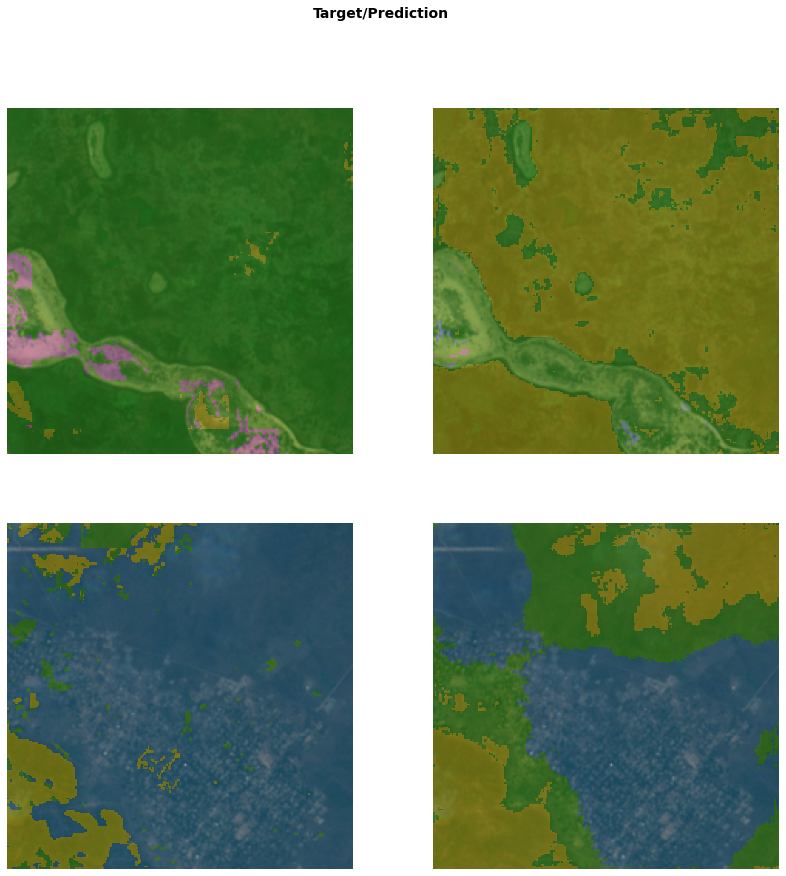

In [ ]:
learn.show_results(max_n=12, figsize=(14,14))

We export the model to use it later for inference without the need to train it again.

In [ ]:
# save the model
learn.export('lcn_unet_resnet50.pkl')

And copy the file from Google Colab machine drive to Google Drive folder of Omdena Red Cross

In [ ]:
!cp 'landcovernet_final/lcn_unet_resnet50.pkl' 'drive/My Drive/Omdena/Data/landcovernet'